In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [22]:
df = pd.read_csv(r"E:\Price_Prediction\data\car_sales_data.csv")

In [3]:
df.head()

,Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Price
0,Ford,Fiesta,1.0,Petrol,2002,127300,3074
1,Porsche,718 Cayman,4.0,Petrol,2016,57850,49704
2,Ford,Mondeo,1.6,Diesel,2014,39190,24072
3,Toyota,RAV4,1.8,Hybrid,1988,210814,1705
4,VW,Polo,1.0,Petrol,2006,127869,4101


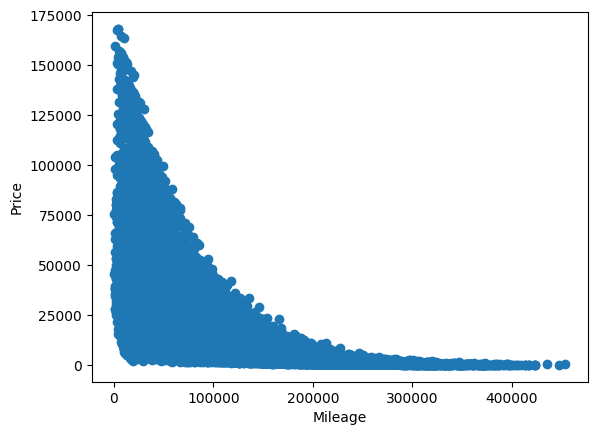

In [4]:
plt.scatter(df['Mileage'], df['Price'])
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

In [5]:
X = df[['Mileage']] 
y = df['Price']

print(X)
print(y)

       Mileage
0       127300
1        57850
2        39190
3       210814
4       127869
...        ...
49995    28664
49996   105120
49997     4030
49998    26468
49999   109300

[50000 rows x 1 columns]
0          3074
1         49704
2         24072
3          1705
4          4101
          ...  
49995    113006
49996      9430
49997     49852
49998     23630
49999     10400
Name: Price, Length: 50000, dtype: int64


In [6]:
#Data Cleaning and Outlier Handling

df['Mileage'] = pd.to_numeric(df['Mileage'].astype(str).str.replace(',', ''), errors='coerce')
df['Price']   = pd.to_numeric(df['Price'].astype(str).str.replace(',', ''), errors='coerce')

df.dropna(subset=['Mileage', 'Price'], inplace=True)
df.reset_index(drop=True, inplace=True)
print("Data types converted and missing values dropped.")


# Using the IQR method to remove outliers 
print(f"\nShape before outlier removal: {df.shape}")

Q1 = df[['Mileage', 'Price']].quantile(0.25)
Q3 = df[['Mileage', 'Price']].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_cleaned = df[~((df[['Mileage', 'Price']] < lower_bound) | (df[['Mileage', 'Price']] > upper_bound)).any(axis=1)].copy()

print(f"Shape after outlier removal: {df_cleaned.shape}")


#Updating X and y variables to use the final cleaned data

X = df_cleaned[['Mileage']]
y = df_cleaned['Price']

print("\nX and y variables have been updated with cleaned data.")

Data types converted and missing values dropped.

Shape before outlier removal: (50000, 7)
Shape after outlier removal: (46966, 7)

X and y variables have been updated with cleaned data.


In [23]:
# Inspect cleaned data
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Manufacturer         50000 non-null  object 
 1   Model                50000 non-null  object 
 2   Engine size          50000 non-null  float64
 3   Fuel type            50000 non-null  object 
 4   Year of manufacture  50000 non-null  int64  
 5   Mileage              50000 non-null  int64  
 6   Price                50000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 2.7+ MB


,Engine size,Year of manufacture,Mileage,Price
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.773058,2004.209440,112497.320700,13828.903160
std,0.734108,9.645965,71632.515602,16416.681336
min,1.000000,1984.000000,630.000000,76.000000
25%,1.400000,1996.000000,54352.250000,3060.750000
50%,1.600000,2004.000000,100987.500000,7971.500000
75%,2.000000,2012.000000,158601.000000,19026.500000
max,5.000000,2022.000000,453537.000000,168081.000000


In [24]:
#Splitting into train and test
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print(f"Training set contains {X_train.shape[0]} samples.")
print(f"Testing set contains {X_test.shape[0]} samples.")

Training set contains 37572 samples.
Testing set contains 9394 samples.


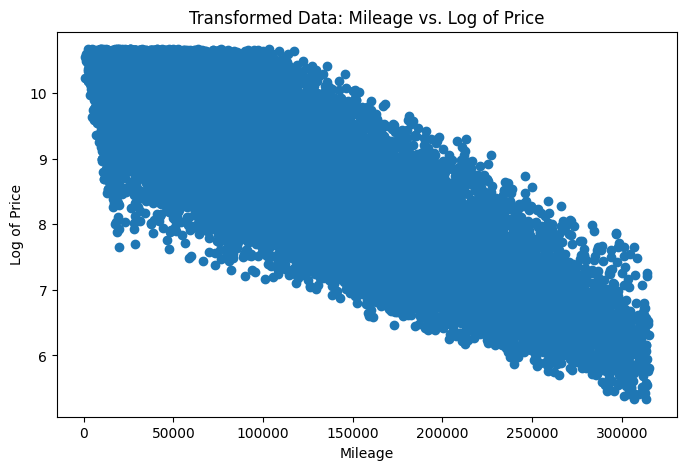

In [26]:
# Apply the Logarithmic Transformation to the target variable
y_train_log = np.log1p(y_train)

# Visualizing the transformed relationship
plt.figure(figsize=(8, 5))
plt.scatter(X_train, y_train_log)
plt.title('Transformed Data: Mileage vs. Log of Price')
plt.xlabel('Mileage')
plt.ylabel('Log of Price')
plt.show()

In [27]:
# Training a Linear Regression model on the transformed data
from sklearn.linear_model import LinearRegression

In [28]:
log_model = LinearRegression()
log_model.fit(X_train, y_train_log)

print("Linear Regression model has been trained on the log-transformed data.")

Linear Regression model has been trained on the log-transformed data.


In [30]:
#Predict on the test set and convert back to original scale [log->exp]

log_predictions = log_model.predict(X_test)

price_predictions = np.expm1(log_predictions)

print("Predictions made on the test set and converted back to the original price scale.")
print("\nFirst 5 Predicted Prices:")
print(price_predictions[:5])

Predictions made on the test set and converted back to the original price scale.

First 5 Predicted Prices:
[ 1313.30912773  1857.37401455 10218.59014787 13792.12622923
 21834.89109734]


In [31]:
#Evaluate the model using standard metrics
from sklearn.metrics import mean_squared_error, r2_score

In [32]:
mse = mean_squared_error(y_test, price_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, price_predictions)

print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"R2 Score: {r2:.3f}")

Root Mean Squared Error (RMSE): $6099.24
R2 Score: 0.648


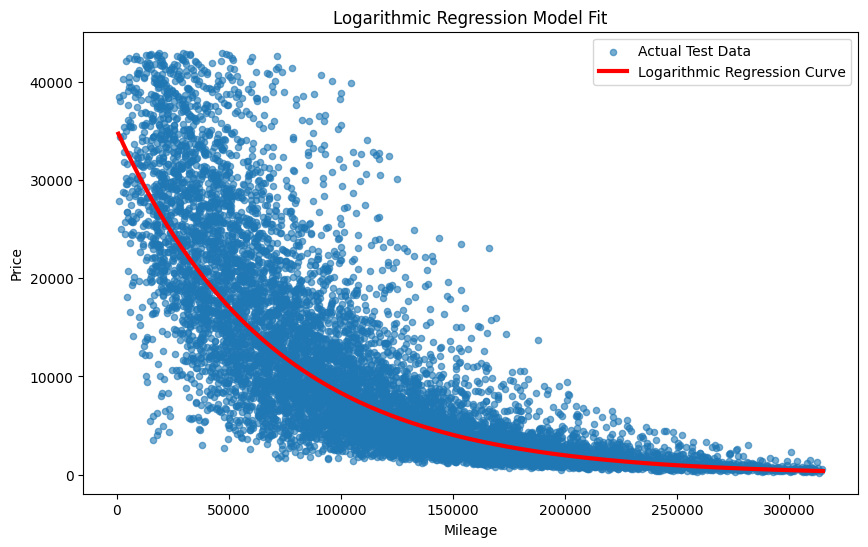

In [34]:
#Plot actual vs predicted and the logarithmic regression curve
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, label='Actual Test Data', s=20, alpha=0.6)

X_range = pd.DataFrame(np.linspace(X['Mileage'].min(), X['Mileage'].max(), 200), columns=['Mileage'])
log_range_pred = log_model.predict(X_range)
price_range_pred = np.expm1(log_range_pred)

plt.plot(X_range, price_range_pred, color='red', linewidth=3, label='Logarithmic Regression Curve')

plt.title('Logarithmic Regression Model Fit')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.legend()
plt.show()

In [35]:
#Predict the price for a new mileage value

new_mileage = float(input("Enter the mileage of the car: "))

new_car_data = pd.DataFrame({'Mileage': [new_mileage]})

#Predicting the price in the log scale
log_price_prediction = log_model.predict(new_car_data)

#Converting the prediction back to the original price scale
predicted_price = np.expm1(log_price_prediction)

print(f"The predicted price for a car with {new_mileage} mileage is: ${predicted_price[0]:,.2f}")

Enter the mileage of the car:  61332


The predicted price for a car with 61332.0 mileage is: $14,518.02


In [36]:
import joblib

In [37]:
joblib.dump(log_model, 'model.pkl')
print("Model saved as model.pkl")

Model saved as model.pkl
